In [5]:
from Meningioma.preprocessing.tools.remove_extra_channels import remove_first_channel
from Meningioma.preprocessing.tools.nrrd_to_nifti import nifti_write_3d
from Meningioma.preprocessing.tools.reorient import reorient_images
from Meningioma.preprocessing.tools.resample import resample_images
from Meningioma.preprocessing.tools.casting import cast_volume_and_mask
from Meningioma.preprocessing.tools.denoise_susan import denoise_susan
from Meningioma.preprocessing.tools.bias_field_corr_n4 import n4_bias_field_correction, n4_bias_field_correction_monitored, generate_brain_mask_sitk
from Meningioma.preprocessing.tools.skull_stripping.ants_bet import ants_brain_extraction
from Meningioma.preprocessing.tools.skull_stripping.fsl_bet import fsl_bet_brain_extraction
from Meningioma.preprocessing.tools.padding import pad_in_plane
from Meningioma.preprocessing.tools.registration.ants_sri24_reg import register_to_sri24_with_mask, register_image_to_sri24


import os
import numpy as np
import pandas as pd
import SimpleITK as sitk
import time
import nrrd
import matplotlib.pyplot as plt
import scienceplots 
plt.style.use(['science','notebook'])
from typing import List, Tuple, Dict, Any

PULSES: List[str] = ["T1", "T1SIN", "T2", "SUSC"]
PATIENT: str = "P1"
ROOT: str = "/home/mariopasc/Python/Datasets/Meningiomas/Meningioma_Adquisition"
PROCESSED_DATASET_FOLDER: str = "/home/mariopasc/Python/Datasets/Meningiomas/Meningioma_Processed"
ATLAS_ROOT: str = "/home/mariopasc/Python/Datasets/Meningiomas/ATLAS/sri24_spm8/templates"


In [9]:
def pipeline(pulses: List[str] = PULSES, 
             traspose_tuple: Tuple[int, int, int] = (2, 1, 0),
             denoise:bool = False) -> Dict[str, Any]:

    results = {}

    for pulse in pulses:
        print(f"========== {pulse} ==========")

        volume_nrrd_path = os.path.join(ROOT, "RM", pulse, PATIENT, f"{pulse}_{PATIENT}.nrrd")
        mask_path = os.path.join(ROOT, "RM", pulse, PATIENT, f"{pulse}_{PATIENT}_seg.nrrd")

        patient_new_path = os.path.join(PROCESSED_DATASET_FOLDER, "RM", pulse, PATIENT)
        patient_new_volume = os.path.join(patient_new_path, f"{pulse}_{PATIENT}.nii.gz")
        os.makedirs(patient_new_path, exist_ok=True)

        t0 = time.time()
        # (Optional) Remove channel if multi-component
        volume_original, header_nrrd = remove_first_channel(nrrd_path=volume_nrrd_path, channel=0, verbose=True) 

        # Pre. Load original volume and mask
        mask = sitk.ReadImage(mask_path)

        # Pre. Save the original volume as niigz
        nifti_write_3d(volume=(volume_original, header_nrrd), out_file=patient_new_volume, verbose=True)

        print(f"Wrote nifti file in {time.time() - t0} seconds")
        t0 = time.time()

        # Read volume & mask
        volume_img = sitk.ReadImage(patient_new_volume) 

        # Cast
        cast_vol, cast_mask = cast_volume_and_mask(volume_img, mask)

        # (Optional) Reorient
        reor_vol, reor_mask = reorient_images(cast_vol, cast_mask, orientation="LPS")

        # Resample to 1 mm isotropic
        resampled_volume, resampled_mask = resample_images(reor_vol, reor_mask, new_spacing=(1,1,1))

        print(f"Cast, reorient, and resample in {time.time() - t0} seconds")

        if denoise: 
            t0 = time.time()
            susan_vol = denoise_susan(image_sitk=resampled_volume, brightness_threshold=0.001, fwhm=0.5, dimension=3, verbose=True)
            print(f"Denoising in {time.time() - t0} seconds")


        t0 = time.time()
        _, mask_brain = generate_brain_mask_sitk(volume_sitk=resampled_volume, 
                                            threshold_method="li", 
                                            structure_size_2d=7, iterations_2d=3, 
                                            structure_size_3d=3, iterations_3d=1)

        corrected_vol, final_field, conv_log = n4_bias_field_correction_monitored(image_sitk=resampled_volume, 
                                                                                shrink_factor=4, 
                                                                                max_iterations=100, 
                                                                                control_points=6, 
                                                                                bias_field_fwhm=0.1, 
                                                                                mask_sitk=mask_brain,
                                                                                verbose=True)
        print(f"Anatomical parts mask and BFCN4 in {time.time() - t0} seconds")

        t0 = time.time()

        extracted_brain_fsl, extracted_mask_fsl = fsl_bet_brain_extraction(input_image_sitk=corrected_vol, 
                                                                           frac=0.5, 
                                                                           robust=True, 
                                                                           vertical_gradient=0, 
                                                                           skull=False, 
                                                                           verbose=True)
        print(f"Brain mask in {time.time() - t0} seconds")

        # For anatomical pulses, register to SRI24
        if pulse in ["T1", "T2"]:
            t0 = time.time()
            atlas_path = f"{ATLAS_ROOT}/{pulse}_brain.nii"
            if not os.path.exists(atlas_path):
                raise FileNotFoundError(f"Atlas not found: {atlas_path}")
            atlas_img = sitk.ReadImage(atlas_path)
            # Call the registration function (assumed to be defined/imported)
            reg_vol, reg_mask, reg_params = register_to_sri24_with_mask(moving_image_sitk=extracted_brain_fsl,
                                                                        moving_mask_sitk=resampled_mask,
                                                                        fixed_image_sitk=atlas_img,
                                                                        output_dir=patient_new_path,
                                                                        output_transform_prefix=f"{pulse}_{PATIENT}_transform",
                                                                        output_image_prefix=f"{pulse}_{PATIENT}_reg_volume",
                                                                        output_mask_prefix=f"{pulse}_{PATIENT}_reg_mask",
                                                                        num_threads=2,
                                                                        verbose=True)
            print(f"Registration to SRI24 completed in {time.time() - t0} seconds")
        else:
            reg_vol, reg_mask, reg_params = None, None, {}
        #### STORE THE DATA ####

        # Transpose accordingly to return [X, Y, Z]:
        volume_original_array = sitk.GetArrayFromImage(volume_original).transpose(traspose_tuple)

        ## processed ##
        # Transpose accordingly to return [X, Y, Z]:
        stg1_volume_processed_array = sitk.GetArrayFromImage(resampled_volume).transpose(traspose_tuple)
        mask_processed_array = sitk.GetArrayFromImage(resampled_mask).transpose(traspose_tuple)

        print(f"Volume processed shape: {stg1_volume_processed_array.shape}\nMask processed shape: {mask_processed_array.shape}")
        indexes_segmentation = [idx for idx in range(mask_processed_array.shape[2]) if np.max(mask_processed_array[:, :, idx]) > 0]
        print(f"{pulse} indexes with segmentation:\n{indexes_segmentation}")
        print("===========================")
        ## Bias field corrected ##
        # Transpose accordingly to return [X, Y, Z]:
        volume_bfcn4_array = sitk.GetArrayFromImage(corrected_vol).transpose(traspose_tuple)
        field_bfcn4_array = sitk.GetArrayFromImage(final_field).transpose(traspose_tuple)
        brain_mask_array = sitk.GetArrayFromImage(mask_brain).transpose(traspose_tuple)
        ## Skull stripping ##
        extracted_brain_array = sitk.GetArrayFromImage(extracted_brain_fsl).transpose(traspose_tuple)
        extracted_mask_fsl_brain_array = sitk.GetArrayFromImage(extracted_mask_fsl).transpose(traspose_tuple)
        ## Registration ##
        if reg_vol and reg_mask:
            registered_volume_array = sitk.GetArrayFromImage(reg_vol).transpose(traspose_tuple)
            registered_mask_array = sitk.GetArrayFromImage(reg_mask).transpose(traspose_tuple)
        else:
            registered_volume_array = []
            registered_mask_array = []

        df = pd.DataFrame(data = {
            "Volume (Original)": [volume_original_array.shape, volume_original_array.dtype, np.max(volume_original_array), np.min(volume_original_array)],
            "Volume (Processed)": [stg1_volume_processed_array.shape, stg1_volume_processed_array.dtype, np.max(stg1_volume_processed_array), np.min(stg1_volume_processed_array)],
            "Mask (Processed)": [mask_processed_array.shape, mask_processed_array.dtype, np.max(mask_processed_array), np.min(mask_processed_array)]
        }, index=["Shape", "dtype", "max", "min"])


        key = f"{PATIENT}_{pulse}"

        entry = {
            'original_volume': volume_original_array,
            'stg1_volume': stg1_volume_processed_array,
            'bfcn4': 
            {
                'vol': volume_bfcn4_array,
                'final_field': field_bfcn4_array,
                'conv_log': conv_log
            },
            'skull_stripping':
            {
                'fsl': extracted_brain_array
            },
            'sri24_registration': {
                'vol': registered_volume_array,
                'params':reg_params
            },
            'mask': 
            {
                'vol': mask_processed_array,
                'indexes_segmentation':indexes_segmentation,
                'brain_mask': brain_mask_array,
                'skull_stripping_fsl': extracted_mask_fsl_brain_array,
                'registered_mask': registered_mask_array,
            },
        }
        
        results[key] = entry

    return results

results = pipeline()

========== T1 ==========
Input volume shape: (416, 512, 192)
Input hdr fields:
 - dimensions: 3
 - sizes: [416 512 192]
 - space directions: [[ 0.46754256838748026 -0.01235863904309036  0.03126936658522083]
 [ 0.01877844950535475  0.45759081350102976 -0.09992286892218787]
 [-0.05533471886129857  0.20022161611266281  0.9065039159753452 ]]
 - kinds: ['domain', 'domain', 'domain']
 - space origin: [ -97.39358329164699 -146.91877981590994  -70.622476993478  ]
Saved 3D NIfTI to: /home/mariopasc/Python/Datasets/Meningiomas/Meningioma_Processed/RM/T1/P1/T1_P1.nii.gz
Wrote nifti file in 1.7141690254211426 seconds
Cast, reorient, and resample in 1.7560670375823975 seconds
[N4] Running with max_iterations=100, control_points=6, bias_field_fwhm=0.1, shrink_factor=4
[N4] Completed. final_iter=2, final_level=4
[N4] Last convergence measurement=0.00015172490384429693
Anatomical parts mask and BFCN4 in 0.6192443370819092 seconds
[FSL BET] Running BET with frac=0.5, robust=True, vertical_gradient=0, s

In [2]:
def ct_brain_extraction_pipeline(
    image_sitk: sitk.Image,
    apply_smoothing: bool = True,
    bet_fractional_intensity: float = 0.01,
    verbose: bool = False
) -> Tuple[sitk.Image, sitk.Image]:
    """
    Implementation of CT brain extraction pipeline as described in the paper.
    
    Steps:
    1. Threshold to brain tissue range (0-100 HU)
    2. Optional: Apply 3D Gaussian smoothing (sigma = 1 mm³)
    3. If smoothing applied, re-threshold to 0-100 HU
    4. Apply FSL BET with specified fractional intensity
    5. Create final brain mask by thresholding > 0 HU and filling holes
    
    Args:
        image_sitk: SimpleITK CT image
        apply_smoothing: Whether to apply Gaussian smoothing
        bet_fractional_intensity: BET fractional intensity (0.35, 0.1, or 0.01)
        verbose: Whether to print processing information
        
    Returns:
        Tuple of (brain_extracted_image, brain_mask)
    """
    if verbose:
        t0 = time.time()
        print(f"Starting CT brain extraction pipeline (smoothing: {apply_smoothing}, "
              f"BET FI: {bet_fractional_intensity})")
    
    # Step 1: Threshold to brain tissue range (0-100 HU)
    threshold_filter = sitk.ThresholdImageFilter()
    threshold_filter.SetLower(0)
    threshold_filter.SetUpper(100)
    threshold_filter.SetOutsideValue(0)
    brain_range_image = threshold_filter.Execute(image_sitk)
    
    if verbose:
        print(f"  Initial thresholding completed in {time.time() - t0:.2f} seconds")
        t0 = time.time()
    
    # Step 2: Optional Gaussian smoothing
    if apply_smoothing:
        # Apply 3D Gaussian filter with sigma = 1mm³
        smoothing_filter = sitk.SmoothingRecursiveGaussianImageFilter()
        smoothing_filter.SetSigma(1.0)
        smoothed_image = smoothing_filter.Execute(brain_range_image)
        
        # Step 3: Re-threshold after smoothing
        threshold_filter = sitk.ThresholdImageFilter()
        threshold_filter.SetLower(0)
        threshold_filter.SetUpper(100)
        threshold_filter.SetOutsideValue(0)
        brain_range_image = threshold_filter.Execute(smoothed_image)
        
        if verbose:
            print(f"  Smoothing and re-thresholding completed in {time.time() - t0:.2f} seconds")
            t0 = time.time()
    
    # Step 4: Apply FSL BET with specified fractional intensity
    # Note: FSL BET should be available in your system
    try:
        # Use the BET wrapper from your existing code
        bet_result, bet_mask = fsl_bet_brain_extraction(
            input_image_sitk=brain_range_image,
            frac=bet_fractional_intensity,
            robust=True,
            vertical_gradient=0,
            skull=False,
            verbose=verbose
        )
        
        if verbose:
            print(f"  BET completed in {time.time() - t0:.2f} seconds")
            t0 = time.time()
        
        # Step 5: Create final brain mask by thresholding > 0 HU and filling holes
        # Threshold the result to get values > 0 HU
        binary_threshold = sitk.BinaryThresholdImageFilter()
        binary_threshold.SetLowerThreshold(0.1)  # Just above 0
        binary_threshold.SetUpperThreshold(float('inf'))
        binary_threshold.SetInsideValue(1)
        binary_threshold.SetOutsideValue(0)
        brain_mask = binary_threshold.Execute(bet_result)
        
        # Fill holes in the mask
        hole_filler = sitk.BinaryFillholeImageFilter()
        hole_filler.SetForegroundValue(1)
        brain_mask = hole_filler.Execute(brain_mask)
        
        # Apply the final mask to the original image
        masking_filter = sitk.MaskImageFilter()
        brain_extracted_image = masking_filter.Execute(image_sitk, brain_mask)
        
        if verbose:
            print(f"  Final mask creation completed in {time.time() - t0:.2f} seconds")
            stats = sitk.StatisticsImageFilter()
            stats.Execute(brain_mask)
            brain_volume_ml = stats.GetSum() * np.prod(image_sitk.GetSpacing()) / 1000
            print(f"  Estimated brain volume: {brain_volume_ml:.2f} ml")
            
        return brain_extracted_image, brain_mask
        
    except Exception as e:
        if verbose:
            print(f"  Error during BET: {str(e)}")
        raise

# Add the window functions if they don't already exist
def apply_window(
    image_sitk: sitk.Image, 
    window_width: float = 400, 
    window_level: float = 40, 
    verbose: bool = False
) -> sitk.Image:
    """
    Apply soft tissue window settings to a CT image to enhance meningioma visibility.
    """
    if verbose:
        print(f"Applying soft tissue window with width={window_width}, level={window_level}")
    
    # Calculate window parameters
    min_value = window_level - window_width/2
    max_value = window_level + window_width/2
    
    # Get array from SimpleITK image
    image_array = sitk.GetArrayFromImage(image_sitk)
    
    # Apply window/level transformation
    windowed_array = np.clip(image_array, min_value, max_value)
    windowed_array = (windowed_array - min_value) / (max_value - min_value)
    
    # Convert back to SimpleITK image
    result = sitk.GetImageFromArray(windowed_array)
    result.CopyInformation(image_sitk)
    
    return result

def hounsfield_unit_clipping(
    image_sitk: sitk.Image, 
    min_value: float = -1000, 
    max_value: float = 1000, 
    verbose: bool = False
) -> sitk.Image:
    """
    Clip Hounsfield units in CT images to specified range.
    
    Args:
        image_sitk: SimpleITK image (typically a CT scan)
        min_value: Minimum value for clipping (default: -1000 HU)
        max_value: Maximum value for clipping (default: 1000 HU)
        verbose: Whether to print processing information
        
    Returns:
        SimpleITK image with clipped values
    """
    if verbose:
        print(f"Clipping Hounsfield units to range [{min_value}, {max_value}]")
    
    # Perform clipping using SimpleITK's thresholding
    clipped_image = sitk.Clamp(image_sitk, 
                               lowerBound=min_value, 
                               upperBound=max_value)
    
    if verbose:
        stats = sitk.StatisticsImageFilter()
        stats.Execute(clipped_image)
        print(f"  After clipping - Min: {stats.GetMinimum()}, Max: {stats.GetMaximum()}")
    
    return clipped_image

def zero_non_brain_pixels(
    image_sitk: sitk.Image, 
    mask_sitk: sitk.Image, 
    verbose: bool = False
) -> sitk.Image:
    """
    Zero out all pixels outside the brain mask.
    
    Args:
        image_sitk: SimpleITK image to be masked
        mask_sitk: SimpleITK binary brain mask
        verbose: Whether to print processing information
        
    Returns:
        SimpleITK image with all non-brain pixels set to zero
    """
    if verbose:
        t0 = time.time()
        print("Zeroing out non-brain pixels in windowed image...")
        
    # Apply the mask using SimpleITK's masking operation
    masking_filter = sitk.MaskImageFilter()
    masked_image = masking_filter.Execute(image_sitk, mask_sitk)
    
    if verbose:
        print(f"  Non-brain pixels zeroed in {time.time() - t0:.2f} seconds")
    
    return masked_image

Processing with brain window...
========== TC ==========
Step 1: Loading and preprocessing image...
Saved 3D NIfTI to: /home/mariopasc/Python/Datasets/Meningiomas/Meningioma_Processed/TC/P1/TC_P1.nii.gz
Step 1 completed in 6.24 seconds
Step 2: Brain extraction...
Starting enhanced CT brain extraction (smoothing: False, BET FI: 0.01, skull erosion: False)
  Initial thresholding completed in 0.00 seconds
[FSL BET] Running BET with frac=0.01, robust=True, vertical_gradient=0, skull=False
[FSL BET] Completed. Outputs:

inskull_mask_file = <undefined>
inskull_mesh_file = <undefined>
mask_file = /tmp/tmps4eiqauo/bet_out_mask.nii.gz
meshfile = <undefined>
out_file = /tmp/tmps4eiqauo/bet_out.nii.gz
outline_file = <undefined>
outskin_mask_file = <undefined>
outskin_mesh_file = <undefined>
outskull_mask_file = <undefined>
outskull_mesh_file = <undefined>
skull_file = <undefined>
skull_mask_file = <undefined>

  BET completed in 3.60 seconds
  Final mask creation completed in 0.17 seconds
  Estim

,Original Volume,Processed Volume,Brain Only,Brain (0-100 HU),Brain (brain),Brain Mask,Registered Brain,Segmentation Mask
Shape,"(271, 512, 512)","(312, 312, 136)","(312, 312, 136)","(312, 312, 136)","(312, 312, 136)","(312, 312, 136)","(240, 240, 155)","(240, 240, 155)"
dtype,int16,float32,float32,float32,float32,uint8,float64,float64
max,2004,1972.56958,380.237,100.0,1.0,1,0.0,0.0
min,-1024,-1049.735962,-31.822981,0.0,0.0,0,0.0,0.0


Saved visualizations to /home/mariopasc/Python/Datasets/Meningiomas/Meningioma_Processed/visualizations/P1_tc_brain_vis.png and /home/mariopasc/Python/Datasets/Meningiomas/Meningioma_Processed/visualizations/P1_tc_brain_vis.svg


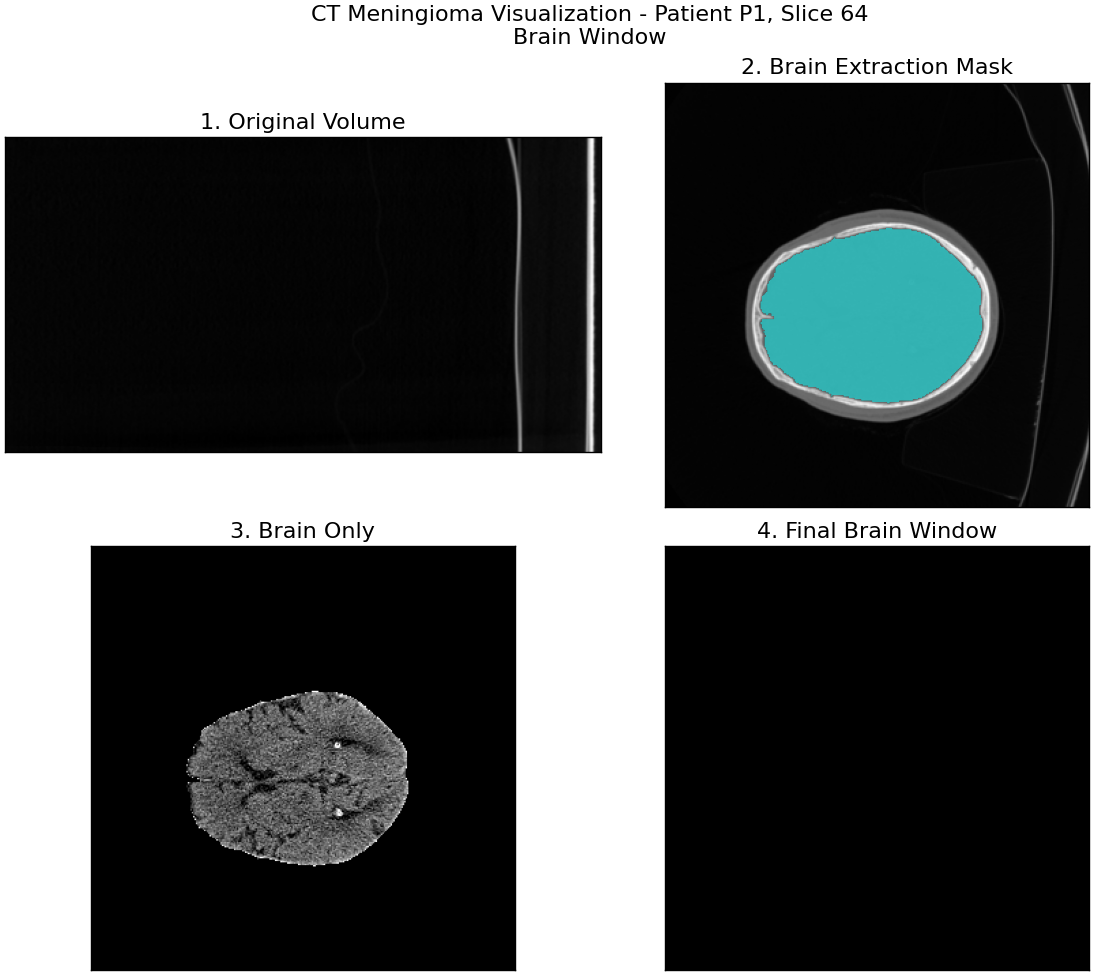

In [23]:
def enhanced_ct_brain_extraction(
    image_sitk: sitk.Image,
    apply_smoothing: bool = True,
    bet_fractional_intensity: float = 0.01,
    perform_skull_erosion: bool = True,
    erosion_radius: int = 1,
    verbose: bool = False
) -> Tuple[sitk.Image, sitk.Image]:
    """
    Enhanced CT brain extraction with better skull removal.

    Source:
        https://www.sciencedirect.com/science/article/pii/S1053811915002700
        But added the perform_skull_erosion steps to further remove skull remnants (only if needed)
    
    Steps:
    1. Threshold to brain tissue range (0-100 HU)
    2. Optional: Apply 3D Gaussian smoothing (sigma = 1 mm³)
    3. If smoothing applied, re-threshold to 0-100 HU
    4. Apply FSL BET with specified fractional intensity
    5. Create brain mask and apply morphological operations to remove skull remnants
    6. Apply the refined mask to the original image
    
    Args:
        image_sitk: SimpleITK CT image
        apply_smoothing: Whether to apply Gaussian smoothing
        bet_fractional_intensity: BET fractional intensity (default: 0.01)
        perform_skull_erosion: Whether to perform additional erosion to remove skull
        erosion_radius: Radius for erosion operation
        verbose: Whether to print processing information
        
    Returns:
        Tuple of (brain_extracted_image, brain_mask)
    """
    if verbose:
        t0 = time.time()
        print(f"Starting enhanced CT brain extraction (smoothing: {apply_smoothing}, "
              f"BET FI: {bet_fractional_intensity}, skull erosion: {perform_skull_erosion})")
    
    # Step 1: Threshold to brain tissue range (0-100 HU)
    threshold_filter = sitk.ThresholdImageFilter()
    threshold_filter.SetLower(0)
    threshold_filter.SetUpper(100)
    threshold_filter.SetOutsideValue(0)
    brain_range_image = threshold_filter.Execute(image_sitk)
    
    if verbose:
        print(f"  Initial thresholding completed in {time.time() - t0:.2f} seconds")
        t0 = time.time()
    
    # Step 2: Optional Gaussian smoothing
    if apply_smoothing:
        # Apply 3D Gaussian filter with sigma = 1mm³
        smoothing_filter = sitk.SmoothingRecursiveGaussianImageFilter()
        smoothing_filter.SetSigma(1.0)
        smoothed_image = smoothing_filter.Execute(brain_range_image)
        
        # Step 3: Re-threshold after smoothing
        threshold_filter = sitk.ThresholdImageFilter()
        threshold_filter.SetLower(0)
        threshold_filter.SetUpper(100)
        threshold_filter.SetOutsideValue(0)
        brain_range_image = threshold_filter.Execute(smoothed_image)
        
        if verbose:
            print(f"  Smoothing and re-thresholding completed in {time.time() - t0:.2f} seconds")
            t0 = time.time()
    
    # Step 4: Apply FSL BET with specified fractional intensity
    try:
        bet_result, bet_mask = fsl_bet_brain_extraction(
            input_image_sitk=brain_range_image,
            frac=bet_fractional_intensity,
            robust=True,
            vertical_gradient=0,
            skull=False,
            verbose=verbose
        )
        
        if verbose:
            print(f"  BET completed in {time.time() - t0:.2f} seconds")
            t0 = time.time()
        
        # Step 5: Create brain mask with additional processing to remove skull
        # Threshold the result to get values > 0 HU
        binary_threshold = sitk.BinaryThresholdImageFilter()
        binary_threshold.SetLowerThreshold(0.1)  # Just above 0
        binary_threshold.SetUpperThreshold(float('inf'))
        binary_threshold.SetInsideValue(1)
        binary_threshold.SetOutsideValue(0)
        brain_mask = binary_threshold.Execute(bet_result)
        
        # Apply additional processing to remove skull remnants
        if perform_skull_erosion:
            # First erode to remove thin connections to skull
            erode_filter = sitk.BinaryErodeImageFilter()
            erode_filter.SetKernelRadius(erosion_radius)
            erode_filter.SetForegroundValue(1)
            erode_filter.SetBackgroundValue(0)
            eroded_mask = erode_filter.Execute(brain_mask)
            
            # Keep only the largest connected component (the brain)
            cc_filter = sitk.ConnectedComponentImageFilter()
            label_map = cc_filter.Execute(eroded_mask)
            
            # Find the largest component
            label_stats = sitk.LabelShapeStatisticsImageFilter()
            label_stats.Execute(label_map)
            
            largest_label = 0
            largest_size = 0
            for label in label_stats.GetLabels():
                if label > 0 and label_stats.GetPhysicalSize(label) > largest_size:
                    largest_size = label_stats.GetPhysicalSize(label)
                    largest_label = label
            
            # Create a mask with only the largest component
            binary_filter = sitk.BinaryThresholdImageFilter()
            binary_filter.SetLowerThreshold(largest_label)
            binary_filter.SetUpperThreshold(largest_label)
            binary_filter.SetInsideValue(1)
            binary_filter.SetOutsideValue(0)
            brain_core = binary_filter.Execute(label_map)
            
            # Dilate the core brain mask slightly, but stay away from edges
            dilate_filter = sitk.BinaryDilateImageFilter()
            dilate_filter.SetKernelRadius(erosion_radius)
            dilate_filter.SetForegroundValue(1)
            dilate_filter.SetBackgroundValue(0)
            dilated_core = dilate_filter.Execute(brain_core)
            
            # Combine with original mask using AND operation to keep only valid brain regions
            brain_mask = sitk.And(dilated_core, brain_mask)
            
            if verbose:
                print(f"  Enhanced skull removal completed in {time.time() - t0:.2f} seconds")
                t0 = time.time()
        
        # Fill holes in the mask
        hole_filler = sitk.BinaryFillholeImageFilter()
        hole_filler.SetForegroundValue(1)
        brain_mask = hole_filler.Execute(brain_mask)
        
        # Apply the final mask to the original image
        masking_filter = sitk.MaskImageFilter()
        brain_extracted_image = masking_filter.Execute(image_sitk, brain_mask)
        
        if verbose:
            print(f"  Final mask creation completed in {time.time() - t0:.2f} seconds")
            stats = sitk.StatisticsImageFilter()
            stats.Execute(brain_mask)
            brain_volume_ml = stats.GetSum() * np.prod(image_sitk.GetSpacing()) / 1000
            print(f"  Estimated brain volume: {brain_volume_ml:.2f} ml")
            
        return brain_extracted_image, brain_mask
        
    except Exception as e:
        if verbose:
            print(f"  Error during brain extraction: {str(e)}")
        raise

    
def tc_pipeline(
    patient: str = PATIENT,
    transpose_tuple: Tuple[int, int, int] = (2, 1, 0),
    denoise: bool = False,
    window_level: str = "soft_tissue"  # Options: "soft_tissue" or "brain"
) -> Dict[str, Any]:
    """
    Process CT (TC) volumes optimized for meningioma detection.
    
    Pipeline steps:
    1. nifti, cast, reorient, resample
    2. brain extraction (no smoothing, no skull erosion)
    3. extract brain tissue using brain mask, apply HU clipping
    4. apply window based on window_level parameter
    5. ensure everything outside brain mask is zero
    
    Args:
        patient: Patient ID
        transpose_tuple: Axis order for transposing the final results
        denoise: Whether to apply denoising
        window_level: Type of window to apply ("soft_tissue" or "brain")
        
    Returns:
        Dictionary containing the processed data
    """
    results = {}
    pulse = "TC"  # There's only one pulse for TC
    
    print(f"========== {pulse} ==========")
    
    # Step 1: nifti, cast, reorient, resample
    print("Step 1: Loading and preprocessing image...")
    t0 = time.time()
    
    # Define paths
    volume_nrrd_path = os.path.join(ROOT, "TC", PATIENT, f"{pulse}_{patient}.nrrd")
    mask_path = os.path.join(ROOT, "TC", PATIENT, f"{pulse}_{patient}_seg.nrrd")
    
    patient_new_path = os.path.join(PROCESSED_DATASET_FOLDER, "TC", patient)
    patient_new_volume = os.path.join(patient_new_path, f"{pulse}_{patient}.nii.gz")
    os.makedirs(patient_new_path, exist_ok=True)
    
    # Load original volume and mask
    volume_original, header_nrrd = nrrd.read(volume_nrrd_path)
    volume_original = sitk.GetImageFromArray(volume_original)
    
    # Save the original volume as niigz
    nifti_write_3d(volume=(volume_original, header_nrrd), out_file=patient_new_volume, verbose=True)
    
    # Read volume & mask
    volume_img = sitk.ReadImage(patient_new_volume)
    
    try:
        mask = sitk.ReadImage(mask_path)
        has_mask = True
    except:
        print(f"No mask found for {patient}, creating a dummy mask")
        mask = sitk.Image(volume_img.GetSize(), sitk.sitkUInt8)
        mask.SetOrigin(volume_img.GetOrigin())
        mask.SetSpacing(volume_img.GetSpacing())
        mask.SetDirection(volume_img.GetDirection())
        has_mask = False
    
    # Cast
    cast_vol, cast_mask = cast_volume_and_mask(volume_img, mask)
    
    # Reorient
    reor_vol, reor_mask = reorient_images(cast_vol, cast_mask, orientation="LPS")
    
    # Resample to 1 mm isotropic
    resampled_volume, resampled_mask = resample_images(reor_vol, reor_mask, new_spacing=(1,1,1))
    
    print(f"Step 1 completed in {time.time() - t0:.2f} seconds")
    
    # Step 2: Brain extraction (no smoothing, no skull erosion)
    print("Step 2: Brain extraction...")
    t0 = time.time()
    
    try:
        brain_extracted, brain_mask = enhanced_ct_brain_extraction(
            image_sitk=resampled_volume,
            apply_smoothing=False,
            bet_fractional_intensity=0.01,
            perform_skull_erosion=False,
            verbose=True
        )
        
        # Calculate mask coverage for reporting
        stats = sitk.StatisticsImageFilter()
        stats.Execute(brain_mask)
        mask_coverage = stats.GetSum() / np.prod(resampled_volume.GetSize())
        brain_volume_ml = stats.GetSum() * np.prod(resampled_volume.GetSpacing()) / 1000
        
        print(f"Brain extraction completed in {time.time() - t0:.2f} seconds")
        print(f"Extracted brain volume: {brain_volume_ml:.2f} ml ({mask_coverage*100:.2f}% of image)")
        
        skull_stripped_success = True
    except Exception as e:
        print(f"Warning: Brain extraction failed: {str(e)}")
        brain_extracted = resampled_volume
        brain_mask = sitk.Image(resampled_volume.GetSize(), sitk.sitkUInt8)
        brain_mask.CopyInformation(resampled_volume)
        skull_stripped_success = False
    
    # Step 3: Extract brain tissue using mask, apply HU clipping
    print("Step 3: Applying HU clipping to brain tissue...")
    t0 = time.time()
    
    # Apply the brain mask to the original resampled volume to get brain-only image
    masking_filter = sitk.MaskImageFilter()
    brain_only = masking_filter.Execute(resampled_volume, brain_mask)
    
    # Apply HU clipping specifically for brain tissue
    brain_clipped = hounsfield_unit_clipping(
        image_sitk=brain_only,
        min_value=0,  # Brain tissue range as per paper
        max_value=100,
        verbose=True
    )
    
    print(f"HU clipping completed in {time.time() - t0:.2f} seconds")
    
    # Step 4: Apply window based on window_level parameter
    print(f"Step 4: Applying {window_level} window...")
    t0 = time.time()
    
    if window_level == "brain":
        # Brain window (80/40)
        window_width = 80
        window_level_value = 40
    else:  # Default to soft_tissue
        # Soft tissue window (400/40)
        window_width = 400
        window_level_value = 40
    
    windowed_brain = apply_window(
        image_sitk=brain_only,  # Apply to brain_only, not brain_clipped to preserve full range
        window_width=window_width,
        window_level=window_level_value,
        verbose=True
    )
    
    print(f"Window application completed in {time.time() - t0:.2f} seconds")
    
    # Step 5: Ensure everything outside brain mask is zero
    print("Step 5: Ensuring non-brain pixels are zero...")
    t0 = time.time()
    
    brain_image = zero_non_brain_pixels(
        image_sitk=windowed_brain,
        mask_sitk=brain_mask,
        verbose=True
    )
    
    print(f"Registration to SRI24 T1")
    registered_image, registered_mask, transform_params = register_image_to_sri24( #type: ignore
        moving_image=brain_image,
        moving_mask=resampled_mask,
        config_path="/home/mariopasc/Python/Projects/Meningioma/src/Meningioma/preprocessing/configs/registration_sri24.yaml",
        verbose=True
    )

    print(f"Final processing completed in {time.time() - t0:.2f} seconds")
    
    # Transpose arrays for storage
    volume_original_array = sitk.GetArrayFromImage(volume_original).transpose(transpose_tuple)
    stg1_volume_processed_array = sitk.GetArrayFromImage(resampled_volume).transpose(transpose_tuple)
    brain_mask_array = sitk.GetArrayFromImage(brain_mask).transpose(transpose_tuple)
    brain_only_array = sitk.GetArrayFromImage(brain_only).transpose(transpose_tuple)
    brain_clipped_array = sitk.GetArrayFromImage(brain_clipped).transpose(transpose_tuple)
    windowed_brain_array = sitk.GetArrayFromImage(brain_image).transpose(transpose_tuple)
    registered_volume_array = sitk.GetArrayFromImage(registered_image).transpose(transpose_tuple)
    mask_processed_array = sitk.GetArrayFromImage(registered_mask).transpose(transpose_tuple)

    # Get segmentation indices
    if has_mask:
        indexes_segmentation = [idx for idx in range(mask_processed_array.shape[2]) 
                                if np.max(mask_processed_array[:, :, idx]) > 0]
        print(f"{pulse} indexes with segmentation: {indexes_segmentation}")
    else:
        indexes_segmentation = []
    
    # Display results summary
    print("===========================")
    
    df = pd.DataFrame(data = {
        "Original Volume": [volume_original_array.shape, volume_original_array.dtype, 
                           np.max(volume_original_array), np.min(volume_original_array)],
        "Processed Volume": [stg1_volume_processed_array.shape, stg1_volume_processed_array.dtype, 
                             np.max(stg1_volume_processed_array), np.min(stg1_volume_processed_array)],
        "Brain Only": [brain_only_array.shape, brain_only_array.dtype, 
                       np.max(brain_only_array), np.min(brain_only_array)],
        "Brain (0-100 HU)": [brain_clipped_array.shape, brain_clipped_array.dtype, 
                             np.max(brain_clipped_array), np.min(brain_clipped_array)],
        f"Brain ({window_level})": [windowed_brain_array.shape, windowed_brain_array.dtype, 
                                   np.max(windowed_brain_array), np.min(windowed_brain_array)],
        "Brain Mask": [brain_mask_array.shape, brain_mask_array.dtype, 
                       np.max(brain_mask_array), np.min(brain_mask_array)],
        "Registered Brain": [registered_volume_array.shape, registered_volume_array.dtype, 
                       np.max(registered_volume_array), np.min(registered_volume_array)],
        "Segmentation Mask": [mask_processed_array.shape, mask_processed_array.dtype, 
                              np.max(mask_processed_array), np.min(mask_processed_array)]
    }, index=["Shape", "dtype", "max", "min"])
    
    display(df)
    
    # Store results
    key = f"{patient}_{pulse}"
    
    entry = {
        'original_volume': volume_original_array,
        'stg1_volume': stg1_volume_processed_array,
        'brain_extraction': {
            'volume': brain_only_array,
            'mask': brain_mask_array,
            'clipped': brain_clipped_array,
            'windowed': windowed_brain_array,
            'window_type': window_level,
            "registered": registered_volume_array,
            'success': skull_stripped_success
        },
        'mask': {
            'vol': mask_processed_array,
            'indexes_segmentation': indexes_segmentation,
        },
    }
    
    results[key] = entry
    
    # Visualize results
    visualize_tc_results(results, patient, window_level)
    
    return results

# Update the window function to be more generic
def apply_window(
    image_sitk: sitk.Image, 
    window_width: float = 400, 
    window_level: float = 40, 
    verbose: bool = False
) -> sitk.Image:
    """
    Apply window settings to a CT image.
    
    Args:
        image_sitk: SimpleITK CT image
        window_width: Width of the window in HU
        window_level: Center level of the window in HU
        verbose: Whether to print processing information
        
    Returns:
        SimpleITK image with window applied
    """
    if verbose:
        print(f"Applying window with width={window_width}, level={window_level}")
    
    # Calculate window parameters
    min_value = window_level - window_width/2
    max_value = window_level + window_width/2
    
    # Get array from SimpleITK image
    image_array = sitk.GetArrayFromImage(image_sitk)
    
    # Apply window/level transformation
    windowed_array = np.clip(image_array, min_value, max_value)
    windowed_array = (windowed_array - min_value) / (max_value - min_value)
    
    # Convert back to SimpleITK image
    result = sitk.GetImageFromArray(windowed_array)
    result.CopyInformation(image_sitk)
    
    if verbose:
        stats = sitk.StatisticsImageFilter()
        stats.Execute(result)
        print(f"  After windowing - Min: {stats.GetMinimum():.4f}, Max: {stats.GetMaximum():.4f}")
    
    return result

def zero_non_brain_pixels(
    image_sitk: sitk.Image, 
    mask_sitk: sitk.Image, 
    verbose: bool = False
) -> sitk.Image:
    """
    Zero out all pixels outside the brain mask.
    
    Args:
        image_sitk: SimpleITK image to be masked
        mask_sitk: SimpleITK binary brain mask
        verbose: Whether to print processing information
        
    Returns:
        SimpleITK image with all non-brain pixels set to zero
    """
    if verbose:
        t0 = time.time()
        print("Zeroing out non-brain pixels...")
        
    # Apply the mask using SimpleITK's masking operation
    masking_filter = sitk.MaskImageFilter()
    masked_image = masking_filter.Execute(image_sitk, mask_sitk)
    
    if verbose:
        print(f"  Non-brain pixels zeroed in {time.time() - t0:.2f} seconds")
        stats = sitk.StatisticsImageFilter()
        stats.Execute(masked_image)
        non_zero_count = sitk.GetArrayFromImage(masked_image).astype(bool).sum()
        total_count = np.prod(masked_image.GetSize())
        print(f"  Non-zero pixels: {non_zero_count} ({non_zero_count/total_count*100:.2f}% of total)")
    
    return masked_image

# Update visualization function to handle different window types
def visualize_tc_results(results, patient=PATIENT, window_level="soft_tissue"):
    """
    Visualize the results of the TC pipeline with focus on meningioma detection.
    
    Args:
        results: Dictionary containing the processed data
        patient: Patient ID
        window_level: Window type used ("soft_tissue" or "brain")
    """
    key = f"{patient}_TC"
    result = results[key]
    
    # Find a good slice to visualize
    if len(result['mask']['indexes_segmentation']) > 0:
        slice_idx = result['mask']['indexes_segmentation'][len(result['mask']['indexes_segmentation'])//2]
    else:
        brain_mask = result['brain_extraction']['mask']
        slices_with_brain = []
        for i in range(brain_mask.shape[2]):
            if np.sum(brain_mask[:,:,i]) > 100:
                slices_with_brain.append(i)
        if slices_with_brain:
            slice_idx = slices_with_brain[len(slices_with_brain)//2]
        else:
            slice_idx = brain_mask.shape[2]//2
    
    # Create visualization figure
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f"CT Meningioma Visualization - Patient {patient}, Slice {slice_idx}\n{window_level.title()} Window", 
                 fontsize=16)
    
    # Row 1, Col 1: Original Volume
    axs[0, 0].imshow(result['original_volume'][:, :, slice_idx], cmap='gray')
    axs[0, 0].set_title('1. Original Volume')
    
    # Row 1, Col 2: Brain Mask Overlay
    axs[0, 1].imshow(result['stg1_volume'][:, :, slice_idx], cmap='gray')
    brain_mask_overlay = np.ma.masked_where(
        result['brain_extraction']['mask'][:, :, slice_idx] == 0,
        result['brain_extraction']['mask'][:, :, slice_idx]
    )
    axs[0, 1].imshow(brain_mask_overlay, cmap='cool', alpha=0.5)
    axs[0, 1].set_title('2. Brain Extraction Mask')
    
    # Row 2, Col 1: Brain Only
    axs[1, 0].imshow(result['brain_extraction']['windowed'][:, :, slice_idx], cmap='gray')
    axs[1, 0].set_title('3. Brain Only')
    
    # Row 2, Col 2: Final Windowed Result
    axs[1, 1].imshow(result['brain_extraction']['registered'][:, :, slice_idx], cmap='gray')
    # Add segmentation overlay if available
    if np.max(result['mask']['vol'][:, :, slice_idx]) > 0:
        seg_overlay = np.ma.masked_where(
            result['mask']['vol'][:, :, slice_idx] == 0,
            result['mask']['vol'][:, :, slice_idx]
        )
        axs[1, 1].imshow(seg_overlay, cmap='autumn', alpha=0.7)
    axs[1, 1].set_title(f'4. Final {window_level.title()} Window')
    
    # Remove axis ticks
    for row in axs:
        for ax in row:
            ax.set_xticks([])
            ax.set_yticks([])
    
    plt.tight_layout()
    
    # Save as PNG and SVG
    os.makedirs(os.path.join(PROCESSED_DATASET_FOLDER, "visualizations"), exist_ok=True)
    png_path = os.path.join(PROCESSED_DATASET_FOLDER, "visualizations", f"{patient}_tc_{window_level}_vis.png")
    svg_path = os.path.join(PROCESSED_DATASET_FOLDER, "visualizations", f"{patient}_tc_{window_level}_vis.svg")
    plt.savefig(png_path, dpi=200)
    plt.savefig(svg_path, format='svg')
    print(f"Saved visualizations to {png_path} and {svg_path}")
    
    plt.show()

# Run with brain window - alternative view for brain parenchyma
print("Processing with brain window...")
brain_window_results = tc_pipeline(window_level="brain")

Testing CT brain extraction pipeline...
Original Image Statistics:
  Min: -1049.74, Max: 1972.57
  Mean: -756.39, StdDev: 487.55
  Size: (312, 312, 136)
  Spacing: (1.0, 1.0, 1.0)

Testing BET with fractional intensity 0.35:
Starting CT brain extraction pipeline (smoothing: True, BET FI: 0.35)
  Initial thresholding completed in 0.00 seconds
  Smoothing and re-thresholding completed in 0.04 seconds
[FSL BET] Running BET with frac=0.35, robust=True, vertical_gradient=0, skull=False
[FSL BET] Completed. Outputs:

inskull_mask_file = <undefined>
inskull_mesh_file = <undefined>
mask_file = /tmp/tmp9di67_5r/bet_out_mask.nii.gz
meshfile = <undefined>
out_file = /tmp/tmp9di67_5r/bet_out.nii.gz
outline_file = <undefined>
outskin_mask_file = <undefined>
outskin_mesh_file = <undefined>
outskull_mask_file = <undefined>
outskull_mesh_file = <undefined>
skull_file = <undefined>
skull_mask_file = <undefined>

  BET completed in 4.50 seconds
  Final mask creation completed in 0.11 seconds
  Estimated

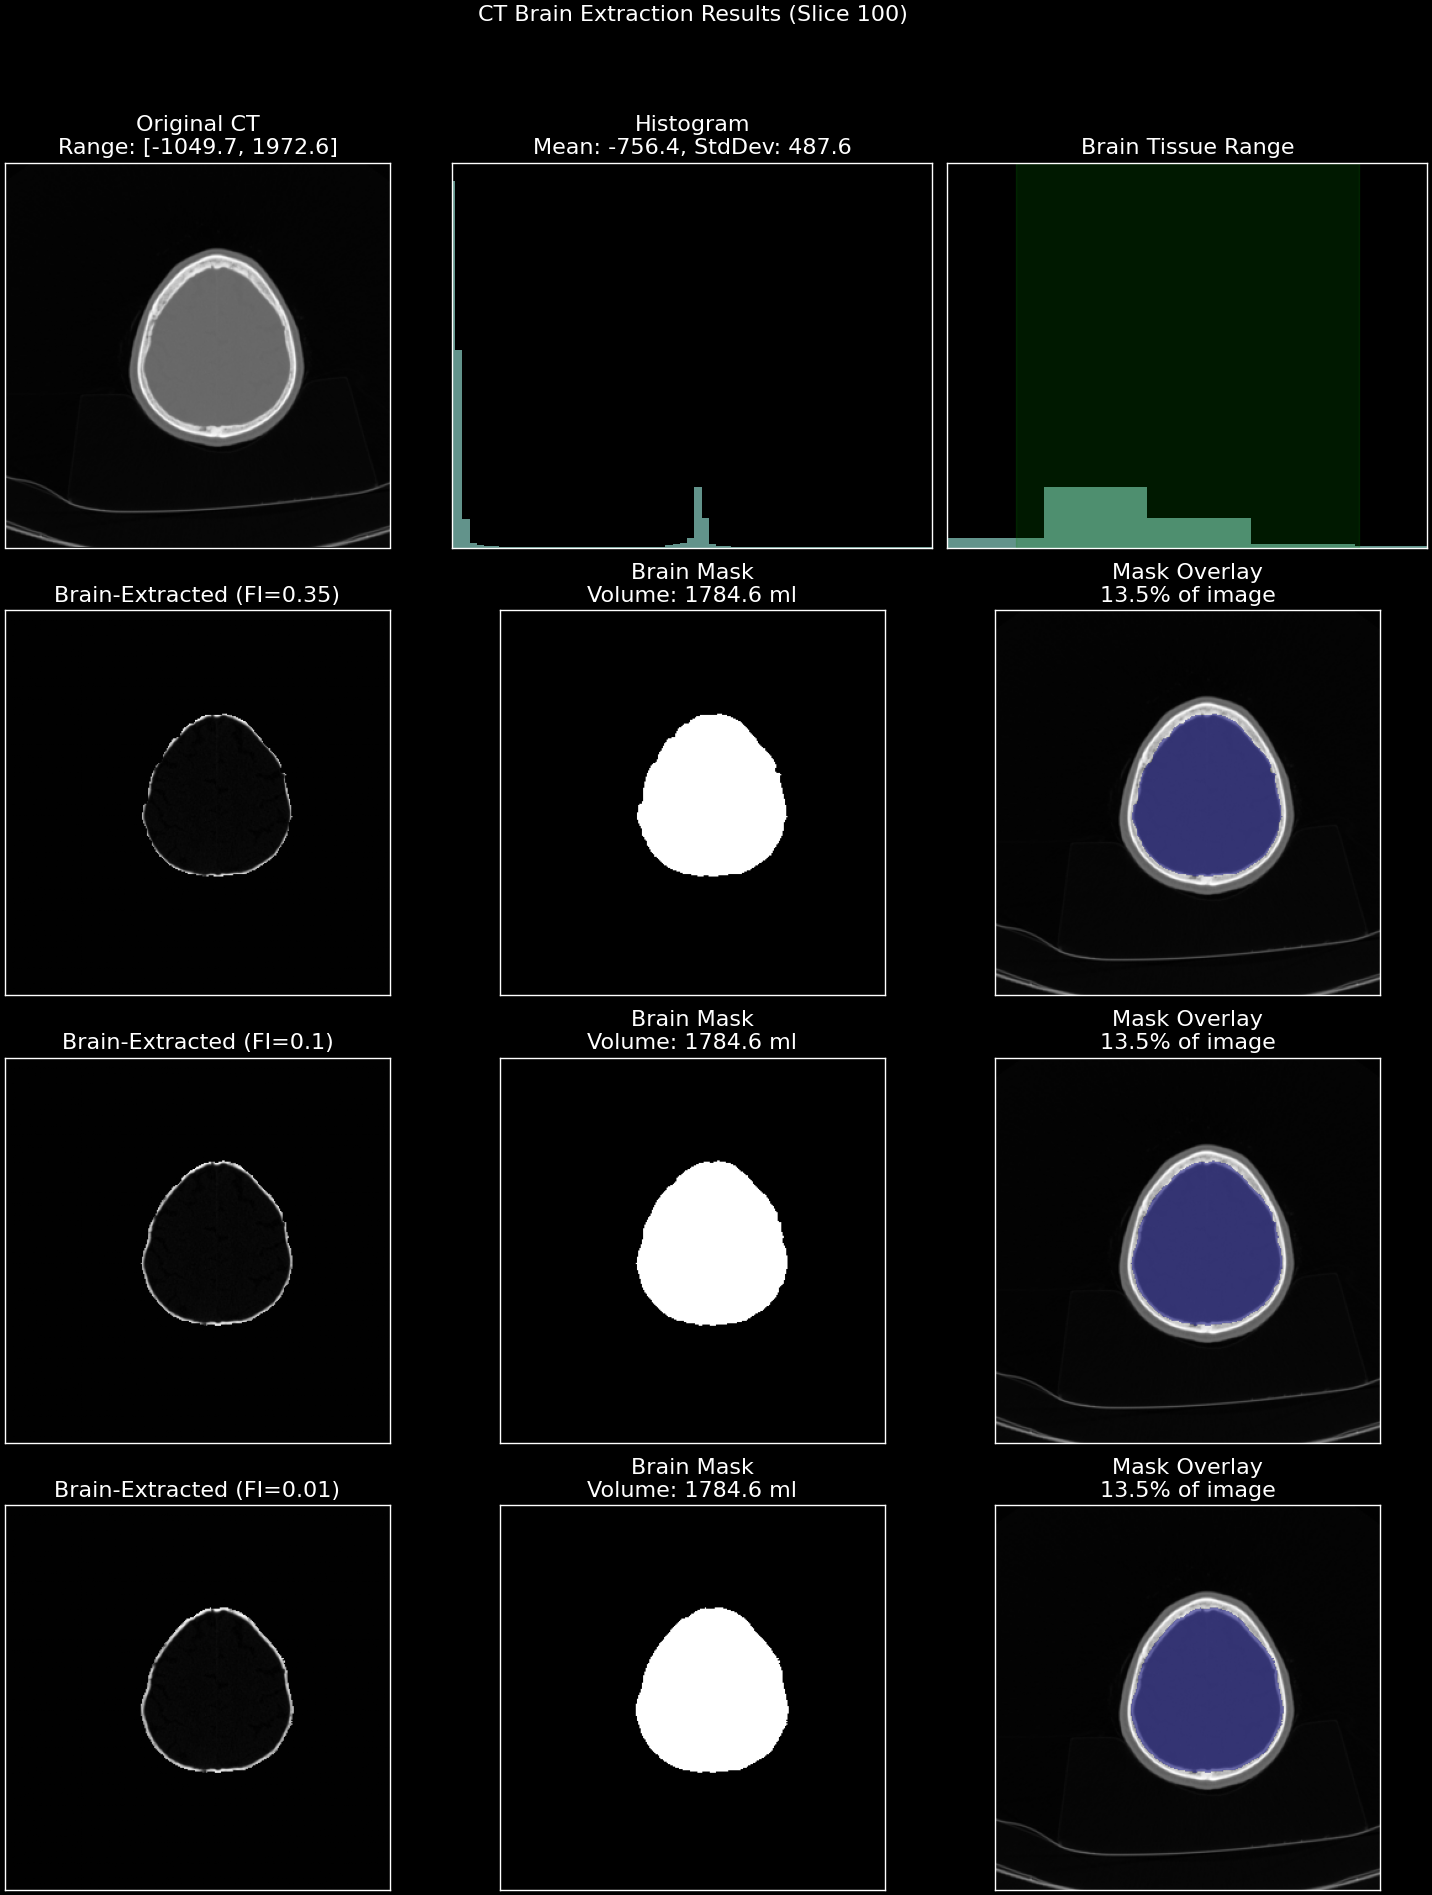

In [ ]:
# Test the CT brain extraction pipeline with visualizations and statistics
def test_ct_brain_extraction(
    image_sitk, 
    slice_idx=None, 
    apply_smoothing=True, 
    test_all_fi=True
):
    """
    Test the CT brain extraction pipeline and visualize results.
    
    Args:
        image_sitk: SimpleITK CT image
        slice_idx: Slice index to display (None for middle slice)
        apply_smoothing: Whether to apply smoothing in the pipeline
        test_all_fi: Test all fractional intensity values from the paper
    """
    if slice_idx is None:
        slice_idx = image_sitk.GetSize()[2] // 2
    
    # Get original image statistics
    stats_orig = sitk.StatisticsImageFilter()
    stats_orig.Execute(image_sitk)
    orig_min = stats_orig.GetMinimum()
    orig_max = stats_orig.GetMaximum()
    orig_mean = stats_orig.GetMean()
    orig_std = stats_orig.GetSigma()
    
    # Get original image as numpy array for display
    orig_array = sitk.GetArrayFromImage(image_sitk)
    
    # Display statistics
    print("Original Image Statistics:")
    print(f"  Min: {orig_min:.2f}, Max: {orig_max:.2f}")
    print(f"  Mean: {orig_mean:.2f}, StdDev: {orig_std:.2f}")
    print(f"  Size: {image_sitk.GetSize()}")
    print(f"  Spacing: {image_sitk.GetSpacing()}")
    
    results = []
    
    # Test different fractional intensity values
    if test_all_fi:
        fi_values = [0.35, 0.1, 0.01]
    else:
        fi_values = [0.01]  # Just use the recommended value
        
    for fi in fi_values:
        print(f"\nTesting BET with fractional intensity {fi}:")
        try:
            brain_extracted, brain_mask = ct_brain_extraction_pipeline(
                image_sitk=image_sitk,
                apply_smoothing=apply_smoothing,
                bet_fractional_intensity=fi,
                verbose=True
            )
            
            # Get statistics for extracted brain
            stats_brain = sitk.StatisticsImageFilter()
            stats_brain.Execute(brain_extracted)
            brain_min = stats_brain.GetMinimum()
            brain_max = stats_brain.GetMaximum()
            brain_mean = stats_brain.GetMean()
            brain_std = stats_brain.GetSigma()
            
            # Get statistics for brain mask
            stats_mask = sitk.StatisticsImageFilter()
            stats_mask.Execute(brain_mask)
            mask_volume = stats_mask.GetSum() * np.prod(image_sitk.GetSpacing()) / 1000  # ml
            mask_percentage = stats_mask.GetSum() / np.prod(image_sitk.GetSize()) * 100  # %
            
            # Get arrays for display
            brain_array = sitk.GetArrayFromImage(brain_extracted)
            mask_array = sitk.GetArrayFromImage(brain_mask)
            
            print(f"Brain-Extracted Image Statistics (FI={fi}):")
            print(f"  Min: {brain_min:.2f}, Max: {brain_max:.2f}")
            print(f"  Mean: {brain_mean:.2f}, StdDev: {brain_std:.2f}")
            print(f"  Brain volume: {mask_volume:.2f} ml ({mask_percentage:.2f}% of image)")
            
            results.append((fi, brain_extracted, brain_mask, brain_array, mask_array))
            
        except Exception as e:
            print(f"  Error with FI={fi}: {str(e)}")
    
    # Create visualization
    if not results:
        print("No successful extractions to visualize")
        return
    
    # Plot results
    n_results = len(results)
    fig, axs = plt.subplots(n_results + 1, 3, figsize=(15, 5 * (n_results + 1)))
    plt.subplots_adjust(hspace=0.4)
    
    # If only one result, wrap axes in list for consistent indexing
    if n_results == 1:
        if not isinstance(axs[0], np.ndarray):
            axs = [axs[0:3], axs[3:6]]
    
    # Title for the figure
    fig.suptitle(f"CT Brain Extraction Results (Slice {slice_idx})", fontsize=16)
    
    # First row: Original image
    axs[0][0].imshow(orig_array[slice_idx], cmap='gray')
    axs[0][0].set_title(f"Original CT\nRange: [{orig_min:.1f}, {orig_max:.1f}]")
    
    # Histogram of original image
    histdata, bins = np.histogram(orig_array.flatten(), bins=100)
    axs[0][1].bar((bins[:-1] + bins[1:]) / 2, histdata, width=np.diff(bins), alpha=0.7)
    axs[0][1].set_title(f"Histogram\nMean: {orig_mean:.1f}, StdDev: {orig_std:.1f}")
    axs[0][1].set_xlim(-1000, 1000)  # Common HU range for display
    
    # Histogram focused on brain tissue range
    axs[0][2].bar((bins[:-1] + bins[1:]) / 2, histdata, width=np.diff(bins), alpha=0.7)
    axs[0][2].set_title("Brain Tissue Range")
    axs[0][2].set_xlim(-20, 120)  # Focus on 0-100 HU range
    axs[0][2].axvspan(0, 100, alpha=0.2, color='green')
    
    # Each subsequent row: Results from a different FI value
    for i, (fi, _, _, brain_array, mask_array) in enumerate(results, start=1):
        # Brain-extracted image
        axs[i][0].imshow(brain_array[slice_idx], cmap='gray')
        axs[i][0].set_title(f"Brain-Extracted (FI={fi})")
        
        # Brain mask
        axs[i][1].imshow(mask_array[slice_idx], cmap='gray')
        axs[i][1].set_title(f"Brain Mask\nVolume: {stats_mask.GetSum() * np.prod(image_sitk.GetSpacing()) / 1000:.1f} ml")
        
        # Overlay of mask on original image
        axs[i][2].imshow(orig_array[slice_idx], cmap='gray')
        masked = np.ma.masked_where(mask_array[slice_idx] == 0, mask_array[slice_idx])
        axs[i][2].imshow(masked, cmap='jet', alpha=0.5)
        axs[i][2].set_title(f"Mask Overlay\n{mask_percentage:.1f}% of image")
    
    # Remove axis ticks
    for ax_row in axs:
        for ax in ax_row:
            ax.set_xticks([])
            ax.set_yticks([])
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('ct_brain_extraction_test.svg', format='svg', dpi=300, bbox_inches='tight')
    plt.show()
    
    return results

# Run the test on the resampled volume
print("Testing CT brain extraction pipeline...")
extraction_results = test_ct_brain_extraction(
    resampled_volume, 
    slice_idx=100,  # Adjust this to a relevant slice
    apply_smoothing=True,
    test_all_fi=True  # Test all fractional intensity values
)

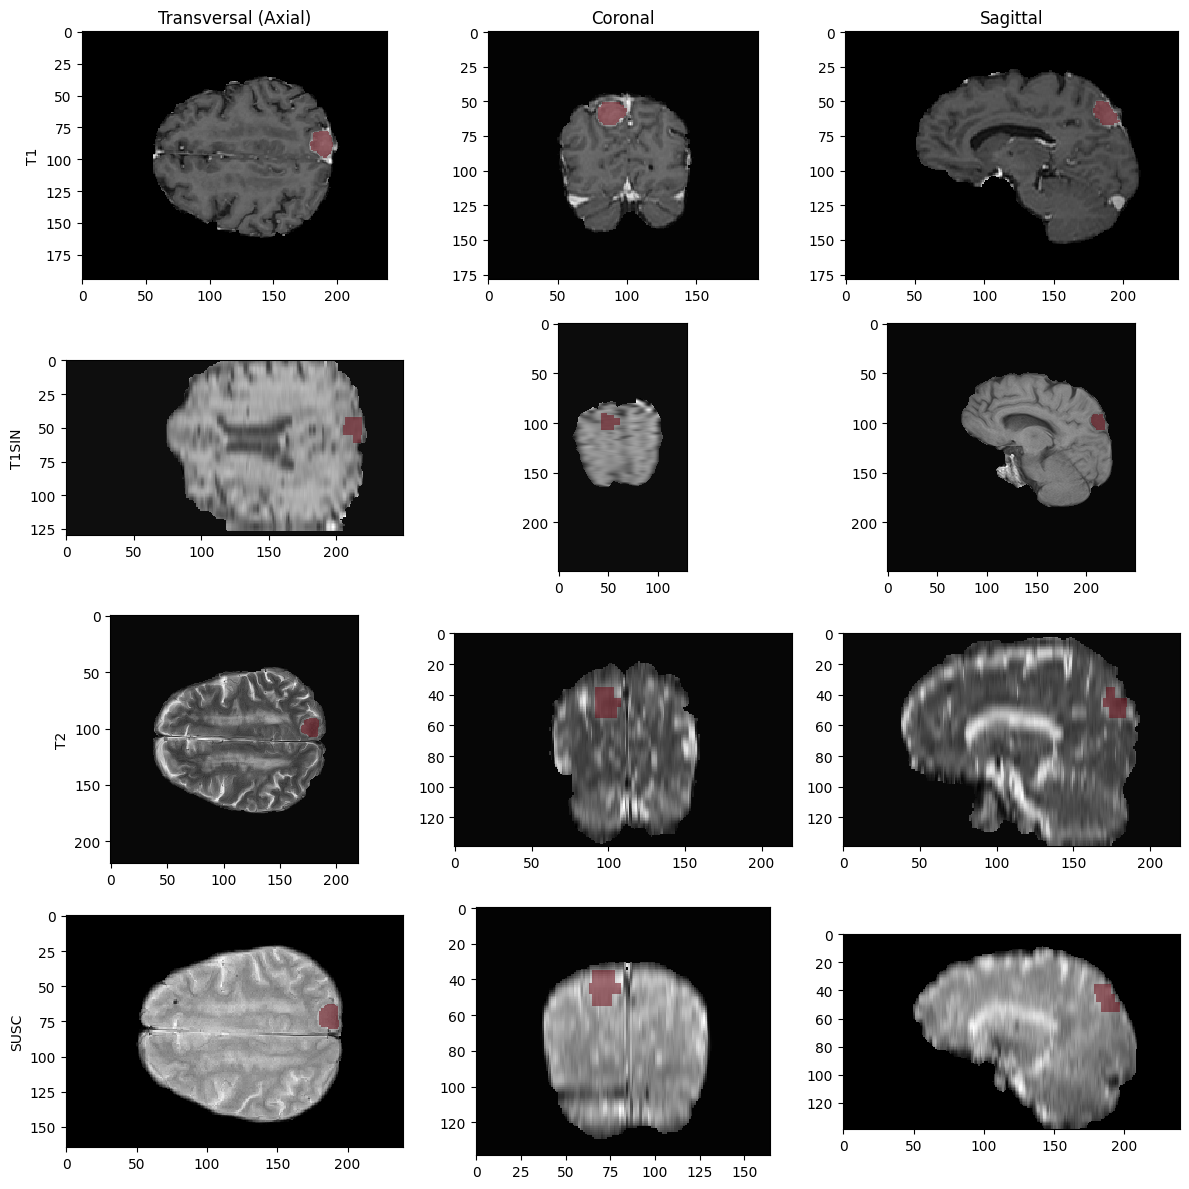

2: [111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]
2: [141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158]


AxisError: axis 2 is out of bounds for array of dimension 1

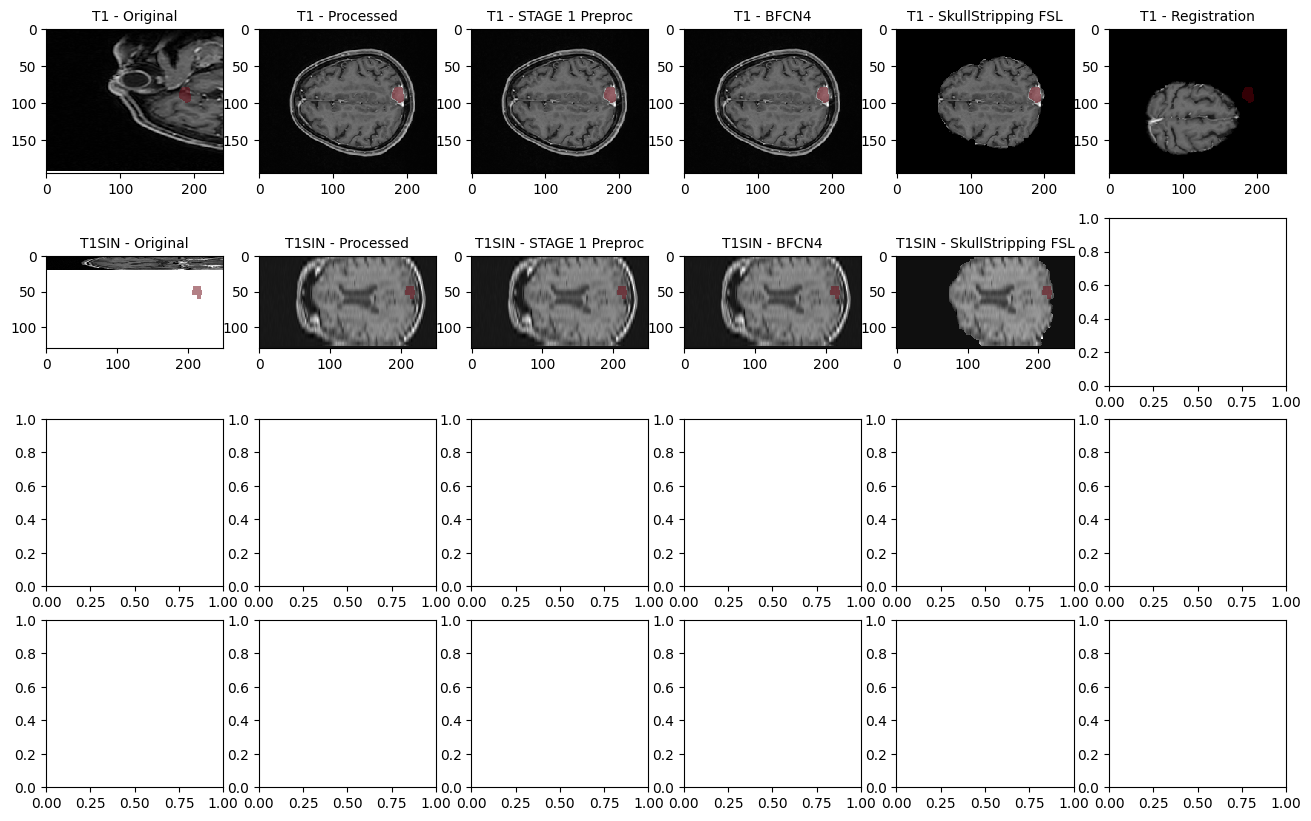

In [9]:
import matplotlib.pyplot as plt

# Example pulses and patient (these should match what you used in the pipeline)
PULSES = ["T1", "T1SIN", "T2", "SUSC"]
PATIENT = "P1"



def visualize_planes_with_same_segmentation_slice(results, pulses, patient, data_key, seg_key=("mask", "vol")):
    """
    Visualizes the transversal (axial), coronal, and sagittal planes for a given volume 
    in the pipeline results, overlaying the segmentation mask on each view.
    
    Rather than taking the middle slice of each dimension independently, this function 
    computes the center-of-mass of the segmentation mask (i.e., the lesion) and uses that 
    coordinate for all three planes. This ensures the lesion is visible in all views.
    
    Parameters:
      results (dict): The pipeline results dictionary.
      pulses (list): List of pulse types (e.g., ["T1", "T1SIN", "T2", "SUSC"]).
      patient (str): Patient identifier.
      data_key (str or tuple): Key to access the desired volume.
          - If a tuple is provided (e.g., ("bfcn4", "vol")), then it is accessed via:
              results[f"{patient}_{pulse}"][data_key[0]][data_key[1]]
          - If a string is provided, then via results[f"{patient}_{pulse}"][data_key].
      seg_key (str or tuple): Key to access the segmentation mask. Defaults to ("mask", "vol").
    
    The function creates a grid with:
      - 4 rows (one per pulse, with the pulse type as the row label)
      - 3 columns: Transversal (Axial), Coronal, and Sagittal.
    """
    num_pulses = len(pulses)
    fig, axes = plt.subplots(nrows=num_pulses, ncols=3, figsize=(12, 3 * num_pulses))
    
    # Set column titles on the top row.
    col_titles = ["Transversal (Axial)", "Coronal", "Sagittal"]
    for ax, title in zip(axes[0], col_titles):
        ax.set_title(title, fontsize=12)
    
    for i, pulse in enumerate(pulses):
        key = f"{patient}_{pulse}"
        
        # Retrieve volume data
        if isinstance(data_key, tuple):
            volume = results[key][data_key[0]][data_key[1]]
        else:
            volume = results[key][data_key]
            
        # Retrieve segmentation mask data
        if isinstance(seg_key, tuple):
            seg_mask = results[key][seg_key[0]][seg_key[1]]
        else:
            seg_mask = results[key][seg_key]
        
        # Compute the center-of-mass of the lesion using the segmentation mask.
        lesion_coords = np.where(seg_mask > 0)
        if lesion_coords[0].size > 0:
            center_x = int(np.mean(lesion_coords[0]))
            center_y = int(np.mean(lesion_coords[1]))
            center_z = int(np.mean(lesion_coords[2]))
        else:
            # Fallback to the volume center if no segmentation is present.
            center_x = volume.shape[0] // 2
            center_y = volume.shape[1] // 2
            center_z = volume.shape[2] // 2
        
        # --- Transversal (Axial) plane: use center_z ---
        ax_trans = axes[i, 0]
        vol_slice = volume[:, :, center_z]
        seg_slice = seg_mask[:, :, center_z]
        ax_trans.imshow(vol_slice, cmap="gray", interpolation="none")
        ax_trans.imshow(np.ma.masked_where(seg_slice == 0, seg_slice), cmap="Reds_r", alpha=0.5, interpolation="none")
        ax_trans.set_ylabel(pulse, fontsize=10)  # Label with pulse type.
        # ax_trans.axis("off")

        # --- Coronal plane: use center_y ---
        ax_cor = axes[i, 1]
        vol_slice = volume[:, center_y, :]
        seg_slice = seg_mask[:, center_y, :]
        # Rotate for natural orientation.
        ax_cor.imshow(np.rot90(vol_slice), cmap="gray", interpolation="none")
        ax_cor.imshow(np.rot90(np.ma.masked_where(seg_slice == 0, seg_slice)), cmap="Reds_r", alpha=0.5, interpolation="none")
        # ax_cor.axis("off")
        
        # --- Sagittal plane: use center_x ---
        ax_sag = axes[i, 2]
        vol_slice = volume[center_x, :, :]
        seg_slice = seg_mask[center_x, :, :]
        ax_sag.imshow(np.rot90(vol_slice), cmap="gray", interpolation="none")
        ax_sag.imshow(np.rot90(np.ma.masked_where(seg_slice == 0, seg_slice)), cmap="Reds_r", alpha=0.5, interpolation="none")
        # ax_sag.axis("off")


    plt.tight_layout()
    plt.show()

#############################
# 1) STEP-BY-STEP VISUALIZATION
#############################
def visualize_pipeline_steps(results_dict, pulses, patient, axis: int = 2):
    """
    Displays a step-by-step view of the pipeline in 4 columns:
    1) Original volume
    2) Processed volume (or your first stage after reorient/resample if you store it)
    3) stg1_volume_processed_array
    4) volume_bfcn4_array

    Rows = different pulses (T1, T1SIN, T2, SUSC).
    """
    # Adapt this list if you add more steps
    steps = [
        ("Original", "original_volume"),
        # If you have a separate entry for an intermediate volume, replace "processed_volume" below
        ("Processed", "stg1_volume"),  
        ("STAGE 1 Preproc", "stg1_volume"),
        ("BFCN4", ("bfcn4", "vol")),
        ("SkullStripping FSL", ("skull_stripping", "fsl")),
        ("Registration", ("sri24_registration", "vol"))
    ]

    # Create subplots
    fig, axes = plt.subplots(nrows=len(pulses), ncols=len(steps), figsize=(16, 10))

    for row, pulse in enumerate(pulses):
        key = f"{patient}_{pulse}"

        # Retrieve the middle slice from indexes_segmentation
        mask_lesion = results_dict[key]["mask"]["vol"]
        if axis == 2:
            seg_indexes = results_dict[key]["mask"]["indexes_segmentation"]
        else:
            seg_indexes = [idx for idx in range(mask_lesion.shape[axis]) 
                           if np.max(np.take(mask_lesion, idx, axis=axis)) > 0]

        print(f"{axis}: {seg_indexes}")

        if seg_indexes:
            mid_idx = seg_indexes[len(seg_indexes) // 2]
        else:
            # Fallback if no segmentation slices exist
            mid_idx = results_dict[key]["original_volume"].shape[2] // 2

        for col, (step_name, dict_path) in enumerate(steps):
            # Some steps might be two-level dictionary references (e.g. bfcn4 -> vol)
            if isinstance(dict_path, tuple):
                array_data = results_dict[key][dict_path[0]][dict_path[1]]
            else:
                array_data = results_dict[key][dict_path]

            ax = axes[row, col]
            ax.imshow(np.take(array_data, indices=mid_idx, axis=axis), cmap="gray", interpolation='none')
            mask_slice = np.take(mask_lesion, mid_idx, axis=axis)
            ax.imshow(np.ma.masked_where(mask_slice == 0, mask_slice), cmap="Reds_r", alpha=0.5, interpolation='none')
            ax.set_title(f"{pulse} - {step_name}", fontsize=10)
            # ax.axis("off")

    plt.tight_layout()
    plt.show()

#############################
# 2) BFCN4 VISUALIZATION
#############################
def visualize_bfcn4(results_dict, pulses, patient, axis:int = 2):
    """
    Shows, for each pulse (row):
    1) BFCN4-corrected volume slice (with optional overlay of the brain mask).
    2) The final field slice.
    3) The convergence log plot.
    """
    # Create subplots: 4 rows (one per pulse), 3 columns
    fig, axes = plt.subplots(nrows=len(pulses), ncols=3, figsize=(15, 10))

    for row, pulse in enumerate(pulses):
        key = f"{patient}_{pulse}"
        
        # Retrieve the middle slice from indexes_segmentation
        mask_lesion = results_dict[key]["mask"]["vol"]
        if axis == 2:
            seg_indexes = results_dict[key]["mask"]["indexes_segmentation"]
        else:
            seg_indexes = [idx for idx in range(mask_lesion.shape[axis]) 
                           if np.max(np.take(mask_lesion, idx, axis=axis)) > 0]
        if seg_indexes:
            mid_idx = seg_indexes[len(seg_indexes) // 2]
        else:
            mid_idx = results_dict[key]["original_volume"].shape[2] // 2

        # BFCN4-corrected volume and final field
        bfcn4_vol = results_dict[key]["bfcn4"]["vol"]
        bfcn4_field = results_dict[key]["bfcn4"]["final_field"]
        conv_log = results_dict[key]["bfcn4"]["conv_log"]

        # If you want to overlay the brain mask, retrieve it
        # (If you saved the actual brain mask in your dictionary; adjust accordingly)
        mask_brain = results_dict[key]["mask"]["brain_mask"]

        # --- Column 1: BFCN4 volume (with mask overlay, if desired) ---
        axes[row, 0].imshow(np.take(bfcn4_vol, mid_idx, axis=axis), cmap="gray", interpolation='none')
        # Overlay mask in red, for example:
        mask_slice = np.take(mask_brain, mid_idx, axis=axis)
        axes[row, 0].imshow(np.ma.masked_where(mask_slice == 0, mask_slice), cmap="Reds_r", alpha=0.5, interpolation='none')
        axes[row, 0].set_title(f"{pulse} - BFCN4", fontsize=10)
        # axes[row, 0].axis("off")

        # --- Column 2: Final N4 Field ---
        axes[row, 1].imshow(np.take(bfcn4_field, mid_idx, axis=axis), cmap="jet", interpolation='none')
        axes[row, 1].set_title("N4 Field", fontsize=10)
        # axes[row, 1].axis("off")

        # --- Column 3: Convergence plot ---
        for level, data_list in conv_log.items():
            # Sort by iteration (if not already)
            data_list = sorted(data_list, key=lambda x: x[0])
            iters = [x[0] for x in data_list]
            costs = [x[1] for x in data_list]
            axes[row, 2].plot(iters, costs, marker='o', linestyle='-', label=f"Level {level}")

        axes[row, 2].set_xlabel("Iteration", fontsize=10)
        axes[row, 2].set_ylabel("Cost", fontsize=10)
        axes[row, 2].set_title("N4 Convergence", fontsize=10)
        axes[row, 2].grid(True)
        axes[row, 2].legend(fontsize=8)

    plt.tight_layout()
    plt.show()

##############################################
# Example usage (assuming 'results' is ready):
##############################################

visualize_planes_with_same_segmentation_slice(results, PULSES, PATIENT, data_key=("skull_stripping", "fsl"))

# 1) Pipeline steps visualization
visualize_pipeline_steps(results, PULSES, PATIENT, axis=2)

# 2) BFCN4 visualization
visualize_bfcn4(results, PULSES, PATIENT)


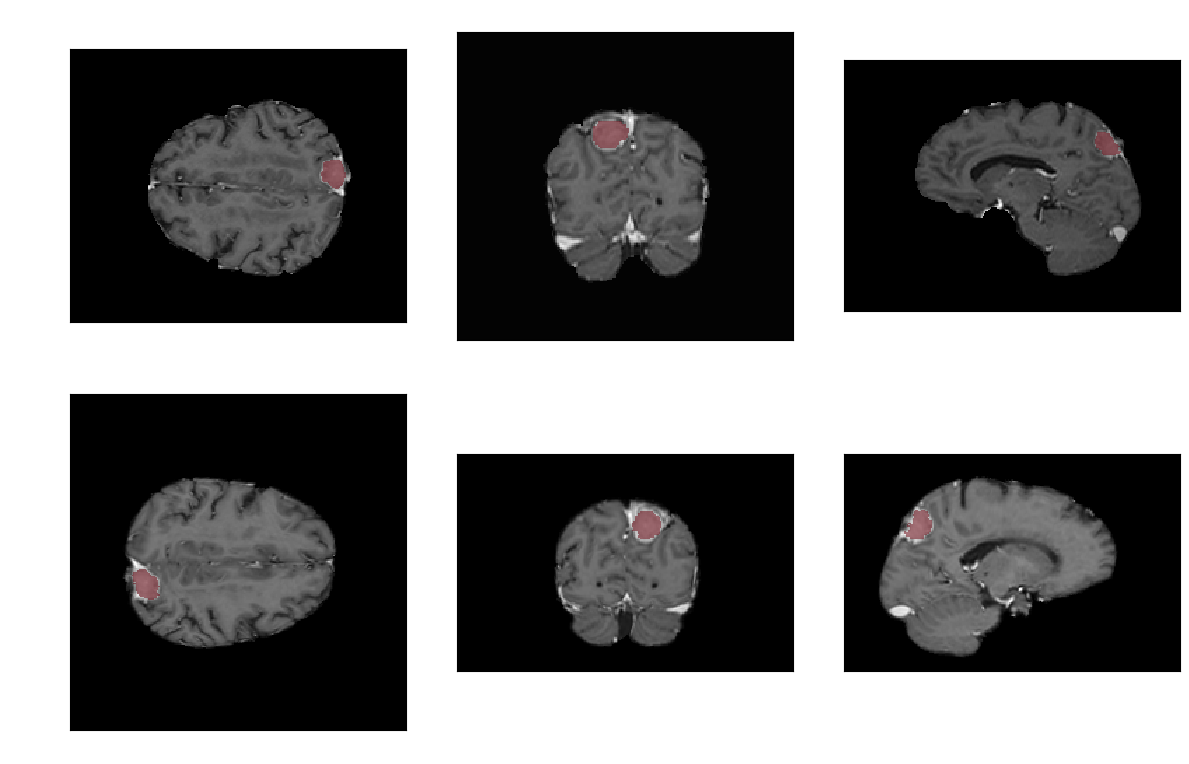

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_pre_post_planes(entry, pulse):
    """
    Visualizes the Transversal (Axial), Coronal, and Sagittal planes for both pre‐registration
    and post‐registration volumes, overlaying the segmentation mask on each view.
    
    The first row corresponds to pre‐registration data, and the second row to post‐registration data.
    
    Parameters:
      entry (dict): Dictionary containing the image arrays.
         Expected keys:
           - Pre-registration volume: entry['skull_stripping']['fsl']
           - Pre-registration mask: entry['mask']['skull_stripping_fsl']
           - Post-registration volume: entry['sri24_registration']['vol']
           - Post-registration mask: entry['mask']['registered_mask']
      pulse (str): Pulse type (e.g., "T1" or "T2"), used for the output filename.
    """
    # Retrieve pre-registration data
    pre_volume = entry['skull_stripping']['fsl']
    pre_mask = entry['mask']['vol']
    
    # Retrieve post-registration data
    post_volume = entry['sri24_registration']['vol']
    post_mask = entry['mask']['registered_mask']
    
    # Set up figure grid: 2 rows (pre, post) x 3 columns (axial, coronal, sagittal)
    nrows, ncols = 2, 3
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8))
    
    # Set axes background to black and tick colors to white
    for row in range(nrows):
        for col in range(ncols):
            ax = axes[row, col]
            ax.set_facecolor('black')
            ax.tick_params(colors='white')
    
    # Column titles (set on the top row)
    col_titles = ["Transversal (Axial)", "Coronal", "Sagittal"]
    for col, title in enumerate(col_titles):
        axes[0, col].set_title(title, fontsize=12, color='white')
    
    # Function to compute the center-of-mass of the segmentation mask
    def compute_center(seg):
        coords = np.where(seg > 0)
        if coords[0].size > 0:
            center_x = int(np.mean(coords[0]))
            center_y = int(np.mean(coords[1]))
            center_z = int(np.mean(coords[2]))
        else:
            center_x = seg.shape[0] // 2
            center_y = seg.shape[1] // 2
            center_z = seg.shape[2] // 2
        return center_x, center_y, center_z

    # Compute centers for pre- and post-registration masks
    pre_center = compute_center(pre_mask)
    post_center = compute_center(post_mask)
    
    # Plot function for a given volume and mask using a specified center coordinate
    def plot_planes(ax_row, volume, mask, center):
        cx, cy, cz = center
        
        # --- Transversal (Axial) plane: slice along the third dimension ---
        ax = axes[ax_row, 0]
        vol_slice = volume[:, :, cz]
        mask_slice = mask[:, :, cz]
        ax.imshow(vol_slice, cmap="gray", interpolation="none")
        ax.imshow(np.ma.masked_where(mask_slice == 0, mask_slice),
                  cmap="Reds_r", alpha=0.5, interpolation="none")
        
        # --- Coronal plane: slice along the second dimension ---
        ax = axes[ax_row, 1]
        vol_slice = volume[:, cy, :]
        mask_slice = mask[:, cy, :]
        ax.imshow(np.rot90(vol_slice), cmap="gray", interpolation="none")
        ax.imshow(np.rot90(np.ma.masked_where(mask_slice == 0, mask_slice)),
                  cmap="Reds_r", alpha=0.5, interpolation="none")
        
        # --- Sagittal plane: slice along the first dimension ---
        ax = axes[ax_row, 2]
        vol_slice = volume[cx, :, :]
        mask_slice = mask[cx, :, :]
        ax.imshow(np.rot90(vol_slice), cmap="gray", interpolation="none")
        ax.imshow(np.rot90(np.ma.masked_where(mask_slice == 0, mask_slice)),
                  cmap="Reds_r", alpha=0.5, interpolation="none")
    
    # Plot pre-registration (row 0)
    plot_planes(0, pre_volume, pre_mask, pre_center)
    # Plot post-registration (row 1)
    plot_planes(1, post_volume, post_mask, post_center)
    
    # Set row labels
    axes[0, 0].set_ylabel("Pre-registration", fontsize=12, color='white')
    axes[1, 0].set_ylabel("Post-registration", fontsize=12, color='white')
    
    plt.tight_layout()
    
    # Save the figure as an SVG file with a black background
    output_filename = f"./scripts/dataset/registration_planes_{pulse}.svg"
    plt.savefig(output_filename, format="svg", facecolor='black')
    plt.show()

# Example usage:
visualize_pre_post_planes(results["P1_T1"], "T1")
